In [31]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [32]:
RELEVANT_CONCEPTS = ["ESA", "GP", "PV", "BDG", "WLSA", "SPC", "PRL", "PLF", "APC"]
csv_file_path = '../ham_concept_dataset/Datasets/metadata/metadata_ground_truth.csv'
df_ground_truth = pd.read_csv(csv_file_path)

json_file_path = '../cbm/skin_lesion_concept_abbreviations-12b.json'
with open(json_file_path, 'r') as f:
    json_data_eval = json.load(f)

total_comparisons = 0
matches = 0
mismatches_details = []

In [33]:
json_data_lookup = {}
for item in json_data_eval:
    if 'image_id' in item and 'concepts' in item:
        json_data_lookup[item['image_id']] = item['concepts']

for index, gt_row in df_ground_truth.iterrows():
    image_id = gt_row['image_id']

    # Get concept values from JSON for this image
    eval_concepts_for_image = {}
    if image_id in json_data_eval:
        json_image_entry = json_data_eval[image_id]
        for concept_abbr in RELEVANT_CONCEPTS:
            eval_concepts_for_image[concept_abbr] = 1 if concept_abbr in json_image_entry else 0
    else:
        # If image_id is not in JSON, all its relevant concepts are considered 0 (absent)
        for concept_abbr in RELEVANT_CONCEPTS:
            eval_concepts_for_image[concept_abbr] = 0

    # Compare for each relevant concept
    for concept_abbr in RELEVANT_CONCEPTS:
        if concept_abbr not in df_ground_truth.columns:
            # This case should ideally not happen if the CSV is well-formed
            # and contains all relevant concept columns.
            # print(f"Warning: Concept {concept_abbr} not found as a column in CSV for image {image_id}. Skipping.")
            continue

        total_comparisons += 1
        gt_value = int(gt_row[concept_abbr])
        eval_value = eval_concepts_for_image[concept_abbr]

        if gt_value == eval_value:
            matches += 1
        else:
            mismatches_details.append({
                "image_id": image_id,
                "concept": concept_abbr,
                "ground_truth_csv": gt_value,
                "evaluation_json": eval_value
            })

# Calculate accuracy
accuracy = (matches / total_comparisons) * 100 if total_comparisons > 0 else 0


In [34]:
print(f"Comparison for concepts: {', '.join(RELEVANT_CONCEPTS)}\n")
print(f"Total image entries in CSV: {len(df_ground_truth)}")
print(f"Total individual concept comparisons made: {total_comparisons}")
print(f"Number of matches: {matches}")
print(f"Number of mismatches: {len(mismatches_details)}")
print(f"Accuracy: {accuracy:.2f}%")

Comparison for concepts: ESA, GP, PV, BDG, WLSA, SPC, PRL, PLF, APC

Total image entries in CSV: 6498
Total individual concept comparisons made: 58482
Number of matches: 49684
Number of mismatches: 8798
Accuracy: 84.96%


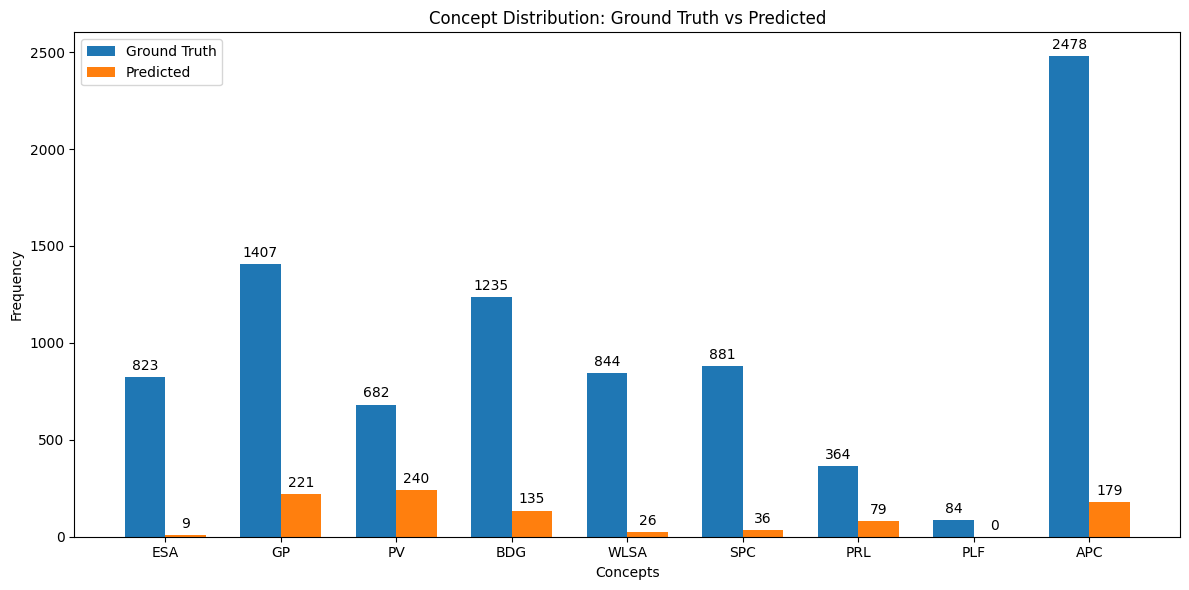

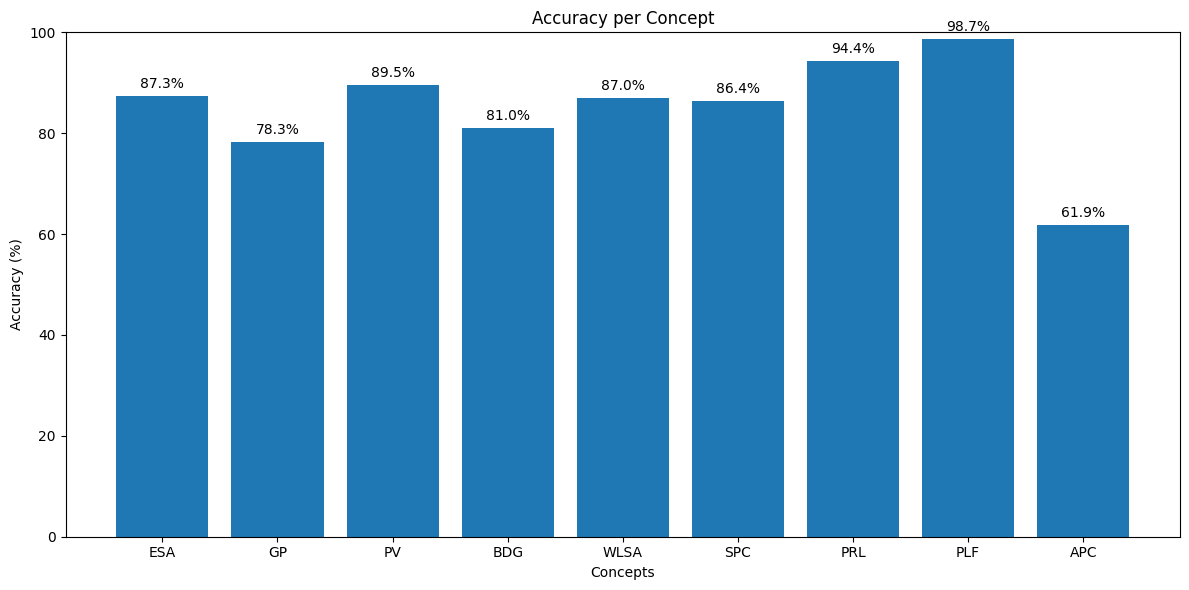

In [35]:
# Create a function to count concept occurrences
def count_concepts(data_source, relevant_concepts):
    """
    Count occurrences of concepts in the data source.
    
    For CSV: data_source is a pandas DataFrame
    For JSON: data_source is a list of dictionaries with 'image_id' and 'concepts' keys
    """
    concept_counts = {concept: 0 for concept in relevant_concepts}
    
    if isinstance(data_source, pd.DataFrame):
        # CSV data
        for concept in relevant_concepts:
            if concept in data_source.columns:
                concept_counts[concept] = data_source[concept].sum()
    else:
        # JSON data
        for item in data_source:
            if 'concepts' in item:
                for concept in item['concepts']:
                    if concept in relevant_concepts:
                        concept_counts[concept] += 1
    
    return concept_counts

# Count concepts in ground truth and predicted data
gt_counts = count_concepts(df_ground_truth, RELEVANT_CONCEPTS)
pred_counts = count_concepts(json_data_eval, RELEVANT_CONCEPTS)

# Plot the distributions
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35
x = np.arange(len(RELEVANT_CONCEPTS))

# Create bars
ax.bar(x - width/2, [gt_counts[c] for c in RELEVANT_CONCEPTS], width, label='Ground Truth')
ax.bar(x + width/2, [pred_counts[c] for c in RELEVANT_CONCEPTS], width, label='Predicted')

# Add labels, title and legend
ax.set_xlabel('Concepts')
ax.set_ylabel('Frequency')
ax.set_title('Concept Distribution: Ground Truth vs Predicted')
ax.set_xticks(x)
ax.set_xticklabels(RELEVANT_CONCEPTS)
ax.legend()

# Add annotations for each bar
for i, concept in enumerate(RELEVANT_CONCEPTS):
    gt_val = gt_counts[concept]
    pred_val = pred_counts[concept]
    ax.annotate(f'{gt_val}', xy=(i - width/2, gt_val), xytext=(0, 3), 
                textcoords="offset points", ha='center', va='bottom')
    ax.annotate(f'{pred_val}', xy=(i + width/2, pred_val), xytext=(0, 3), 
                textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate and display the concept accuracy per concept
concept_accuracy = {}
for concept in RELEVANT_CONCEPTS:
    concept_matches = sum(1 for d in mismatches_details if d['concept'] == concept)
    concept_total = len(df_ground_truth)  # Assuming each image has each concept marked
    concept_accuracy[concept] = ((concept_total - concept_matches) / concept_total) * 100

# Plot concept-wise accuracy
plt.figure(figsize=(12, 6))
plt.bar(RELEVANT_CONCEPTS, [concept_accuracy[c] for c in RELEVANT_CONCEPTS])
plt.xlabel('Concepts')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Concept')
plt.ylim(0, 100)
for i, concept in enumerate(RELEVANT_CONCEPTS):
    plt.text(i, concept_accuracy[concept] + 1, f'{concept_accuracy[concept]:.1f}%', 
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

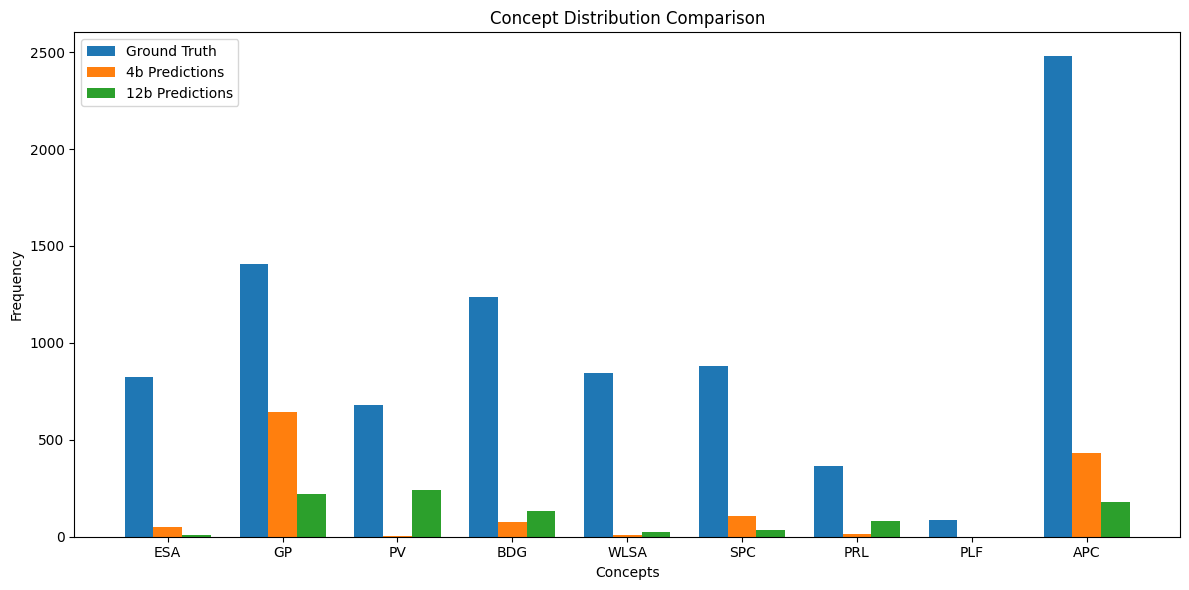

Concept Distribution Comparison Table:
  Concept  Ground Truth  4b Predictions  12b Predictions
0     ESA           823              49                9
1      GP          1407             643              221
2      PV           682               3              240
3     BDG          1235              76              135
4    WLSA           844              11               26
5     SPC           881             109               36
6     PRL           364              16               79
7     PLF            84               0                0
8     APC          2478             433              179


In [36]:
# Load both JSON files
json_file_path_4b = '../cbm/skin_lesion_concept_abbreviations-4b.json'
json_file_path_12b = '../cbm/skin_lesion_concept_abbreviations-12b.json'

with open(json_file_path_4b, 'r') as f:
    json_data_4b = json.load(f)
    
with open(json_file_path_12b, 'r') as f:
    json_data_12b = json.load(f)

# Count concepts in both files
pred_counts_4b = count_concepts(json_data_4b, RELEVANT_CONCEPTS)
pred_counts_12b = count_concepts(json_data_12b, RELEVANT_CONCEPTS)

# Plot comparison of both JSON files
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.25
x = np.arange(len(RELEVANT_CONCEPTS))

# Create bars for ground truth and both predictions
ax.bar(x - width, [gt_counts[c] for c in RELEVANT_CONCEPTS], width, label='Ground Truth')
ax.bar(x, [pred_counts_4b[c] for c in RELEVANT_CONCEPTS], width, label='4b Predictions')
ax.bar(x + width, [pred_counts_12b[c] for c in RELEVANT_CONCEPTS], width, label='12b Predictions')

# Add labels and formatting
ax.set_xlabel('Concepts')
ax.set_ylabel('Frequency')
ax.set_title('Concept Distribution Comparison')
ax.set_xticks(x)
ax.set_xticklabels(RELEVANT_CONCEPTS)
ax.legend()

plt.tight_layout()
plt.show()

# Print a comparison table
comparison_df = pd.DataFrame({
    'Concept': RELEVANT_CONCEPTS,
    'Ground Truth': [gt_counts[c] for c in RELEVANT_CONCEPTS],
    '4b Predictions': [pred_counts_4b[c] for c in RELEVANT_CONCEPTS],
    '12b Predictions': [pred_counts_12b[c] for c in RELEVANT_CONCEPTS]
})
print("Concept Distribution Comparison Table:")
print(comparison_df)

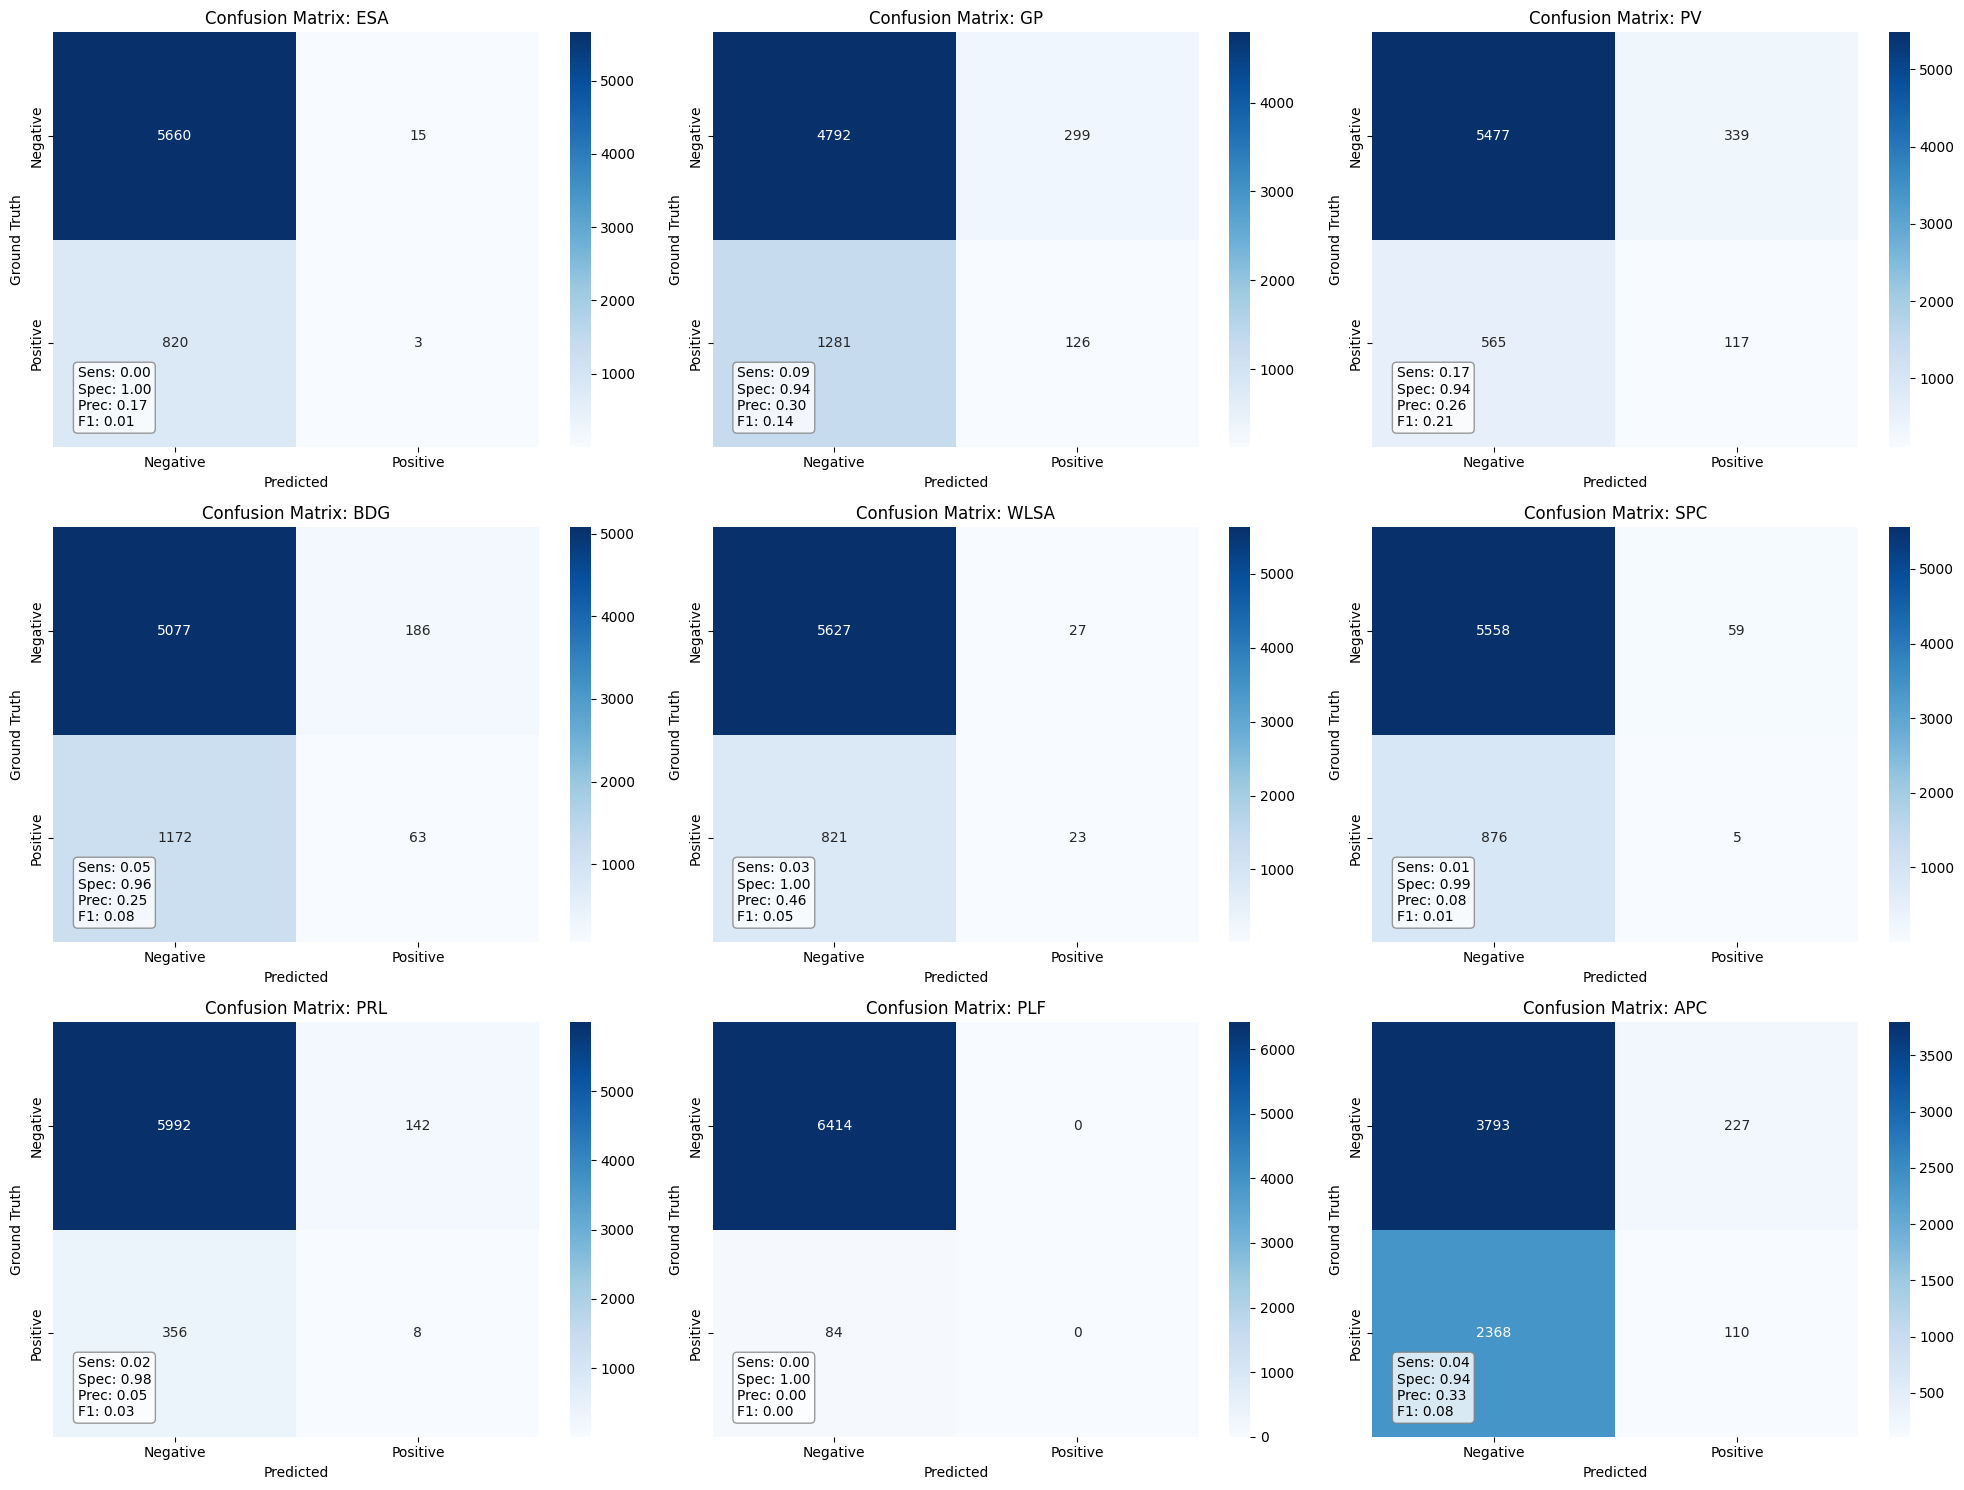

Concept Performance Metrics:
      Sensitivity/Recall  Specificity  Precision  F1 Score  True Positives  \
ESA             0.003645     0.997357   0.166667  0.007134             3.0   
GP              0.089552     0.941269   0.296471  0.137555           126.0   
PV              0.171554     0.941713   0.256579  0.205624           117.0   
BDG             0.051012     0.964659   0.253012  0.084906            63.0   
WLSA            0.027251     0.995225   0.460000  0.051454            23.0   
SPC             0.005675     0.989496   0.078125  0.010582             5.0   
PRL             0.021978     0.976850   0.053333  0.031128             8.0   
PLF             0.000000     1.000000   0.000000  0.000000             0.0   
APC             0.044391     0.943532   0.326409  0.078153           110.0   

      False Positives  True Negatives  False Negatives  Support (Positive)  \
ESA              15.0          5660.0            820.0               823.0   
GP              299.0          479

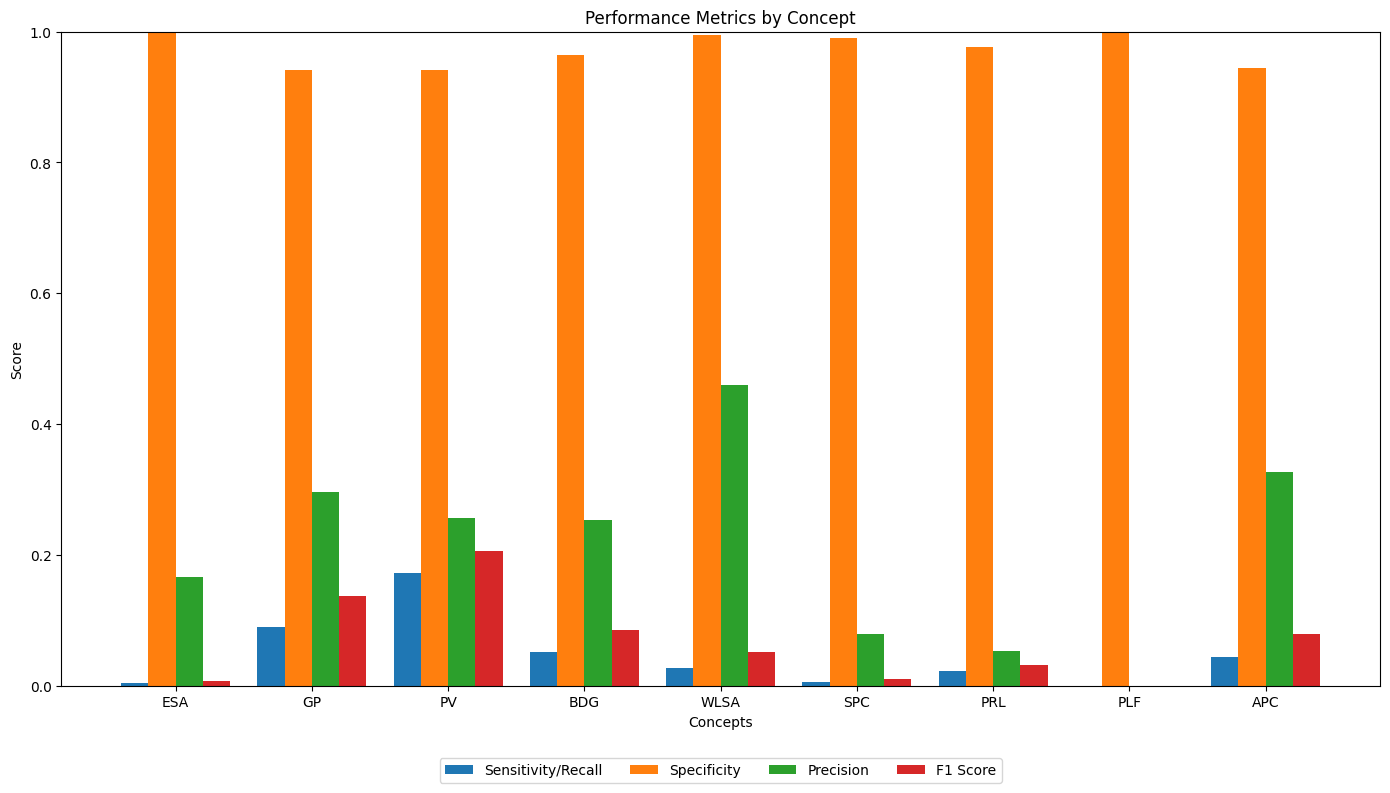

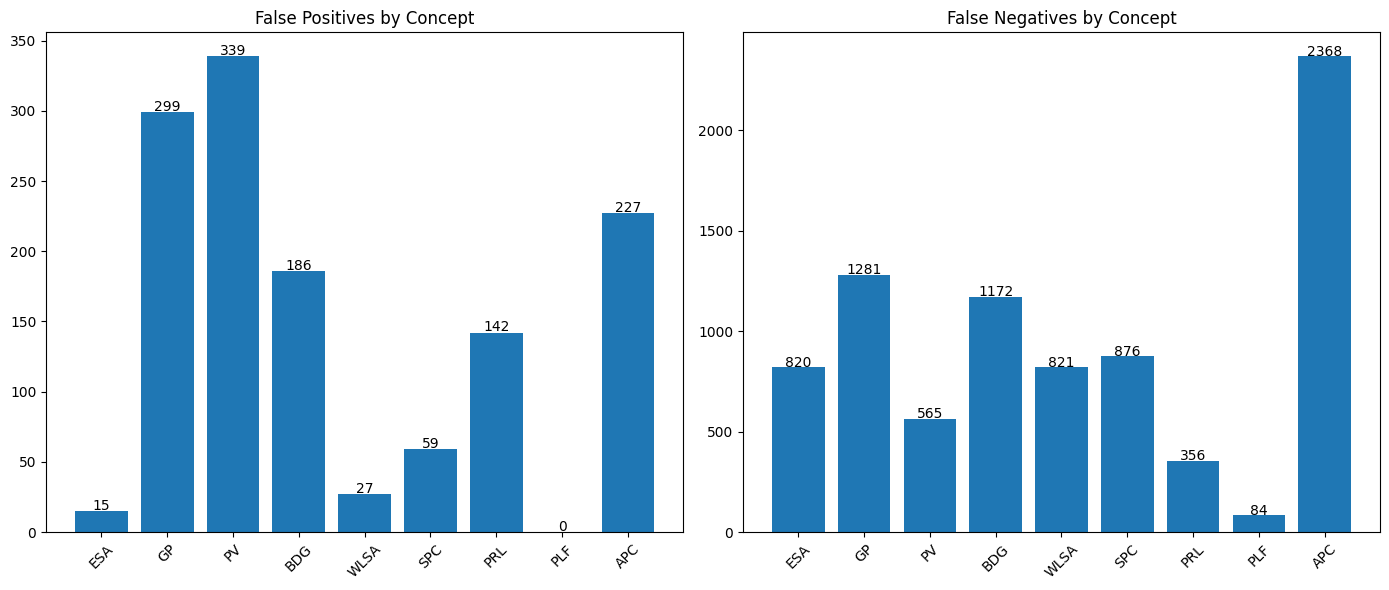

In [37]:
plt.figure(figsize=(20, 15))

# Create a dictionary to store concept-specific metrics
concept_metrics = {}

# Loop through each concept to create a confusion matrix
for i, concept in enumerate(RELEVANT_CONCEPTS):
    # Get ground truth values from dataframe
    gt_values = df_ground_truth[concept].values
    
    # Get predicted values for this concept
    pred_values = []
    for idx, gt_row in df_ground_truth.iterrows():
        image_id = gt_row['image_id']
        # Check if this image_id exists in our JSON lookup
        if image_id in json_data_lookup:
            # Check if this concept is in the list of concepts for this image
            pred_values.append(1 if concept in json_data_lookup[image_id] else 0)
        else:
            # If image not found in JSON, predict 0 (concept absent)
            pred_values.append(0)
    
    # Create confusion matrix
    cm = confusion_matrix(gt_values, pred_values)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    # Store metrics for this concept
    concept_metrics[concept] = {
        'Sensitivity/Recall': sensitivity,
        'Specificity': specificity, 
        'Precision': precision,
        'F1 Score': f1,
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn,
        'Support (Positive)': tp + fn,
        'Support (Negative)': tn + fp
    }
    
    # Plot confusion matrix
    plt.subplot(3, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix: {concept}')
    plt.xlabel('Predicted')
    plt.ylabel('Ground Truth')
    
    # Add metrics as text on the plot
    plt.annotate(f"Sens: {sensitivity:.2f}\nSpec: {specificity:.2f}\nPrec: {precision:.2f}\nF1: {f1:.2f}", 
                 xy=(0.05, 0.05), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Create a metrics dataframe for comparison
metrics_df = pd.DataFrame(concept_metrics).T
print("Concept Performance Metrics:")
print(metrics_df)

# Plot key metrics for each concept
plt.figure(figsize=(14, 8))
metrics_to_plot = ['Sensitivity/Recall', 'Specificity', 'Precision', 'F1 Score']
x = np.arange(len(RELEVANT_CONCEPTS))
width = 0.2
offset = width * 1.5

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + (i - 1.5) * width, 
            [concept_metrics[c][metric] for c in RELEVANT_CONCEPTS], 
            width, label=metric)

plt.xlabel('Concepts')
plt.ylabel('Score')
plt.title('Performance Metrics by Concept')
plt.xticks(x, RELEVANT_CONCEPTS)
plt.ylim(0, 1.0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.tight_layout()
plt.show()

# Add a cell to analyze the most challenging concepts
challenge_metrics = ['False Positives', 'False Negatives']
plt.figure(figsize=(14, 6))

for i, metric in enumerate(challenge_metrics):
    plt.subplot(1, 2, i+1)
    values = [concept_metrics[c][metric] for c in RELEVANT_CONCEPTS]
    plt.bar(RELEVANT_CONCEPTS, values)
    plt.title(f'{metric} by Concept')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Add value labels on top of each bar
    for j, v in enumerate(values):
        plt.text(j, v + 1, str(v), ha='center')

plt.tight_layout()
plt.show()